# **Casas em Boston Regressão linear**

###Importando as bibliotecas

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import statistics as sts
import warnings
from scipy.stats import probplot,shapiro,spearmanr,pearsonr,kendalltau
from statsmodels import stats
from statsmodels.stats.diagnostic import lilliefors
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from google.colab import drive
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

drive.mount('/content/drive')

warnings.filterwarnings('ignore')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/housing.csv')

Mounted at /content/drive


**Entendendo as colunas**

RM: É o número médio de cômodos entre os imoveis no bairro.

LSTAT: É a porcentagem de proprietários no bairro considerados de "classe baixa" (proletariado)

PTRATIO: É a razão entre estudantes e professores nas escolas de ensino fundamental e médio no bairro.

**Coluna alvo**

MEDV: Valor médio das casas        

In [5]:
# Classe para análisar as colunas e plotar gráficos de dispersão
class Analisar():
    def __init__(self,dados):
        self.df = dados

    def analise(self):
        for i in self.df.columns:
            if self.df[i].dtype == 'int64' or self.df[i].dtype == 'float64':
                print(f'\n Nome da coluna:\n {self.df[i].name}')
                print(f'\n Tipo da coluna:\n {self.df[i].dtype}')
                print(f'\n Tipo da coluna:\n {self.df.corr()}')
                print(f'\n Valor media da coluna:\n {round(self.df[i].mean(),2)}')
                print(f'\n Quantidade de linhas da coluna:\n {self.df[i].shape}')
                print(f'\n Valores unicos da coluna:\n {self.df[i].isnull().sum()}')
                print(f'\n Valores nulos da coluna:\n {self.df[i].describe()}')
                fig = px.box(self.df[i])
                fig.update_layout(xaxis=dict(showgrid=False),yaxis=dict(showgrid=False),title=f'Boxplot da coluna {i}',template='plotly_dark')
                fig.show()

    def dispersao(self):
        for e in self.df.columns:
          fig1 = px.scatter(self.df,x=self.df[e],y=self.df.MEDV,title='Correlação Linear',template='plotly_dark')
          fig1.show()

Analise = Analisar(df)
Analise.dispersao()

In [6]:
Analise.analise()


 Nome da coluna:
 RM

 Tipo da coluna:
 float64

 Tipo da coluna:
                RM     LSTAT   PTRATIO      MEDV
RM       1.000000 -0.612033 -0.304559  0.697209
LSTAT   -0.612033  1.000000  0.360445 -0.760670
PTRATIO -0.304559  0.360445  1.000000 -0.519034
MEDV     0.697209 -0.760670 -0.519034  1.000000

 Valor media da coluna:
 6.24

 Quantidade de linhas da coluna:
 (489,)

 Valores unicos da coluna:
 0

 Valores nulos da coluna:
 count    489.000000
mean       6.240288
std        0.643650
min        3.561000
25%        5.880000
50%        6.185000
75%        6.575000
max        8.398000
Name: RM, dtype: float64



 Nome da coluna:
 LSTAT

 Tipo da coluna:
 float64

 Tipo da coluna:
                RM     LSTAT   PTRATIO      MEDV
RM       1.000000 -0.612033 -0.304559  0.697209
LSTAT   -0.612033  1.000000  0.360445 -0.760670
PTRATIO -0.304559  0.360445  1.000000 -0.519034
MEDV     0.697209 -0.760670 -0.519034  1.000000

 Valor media da coluna:
 12.94

 Quantidade de linhas da coluna:
 (489,)

 Valores unicos da coluna:
 0

 Valores nulos da coluna:
 count    489.000000
mean      12.939632
std        7.081990
min        1.980000
25%        7.370000
50%       11.690000
75%       17.120000
max       37.970000
Name: LSTAT, dtype: float64



 Nome da coluna:
 PTRATIO

 Tipo da coluna:
 float64

 Tipo da coluna:
                RM     LSTAT   PTRATIO      MEDV
RM       1.000000 -0.612033 -0.304559  0.697209
LSTAT   -0.612033  1.000000  0.360445 -0.760670
PTRATIO -0.304559  0.360445  1.000000 -0.519034
MEDV     0.697209 -0.760670 -0.519034  1.000000

 Valor media da coluna:
 18.52

 Quantidade de linhas da coluna:
 (489,)

 Valores unicos da coluna:
 0

 Valores nulos da coluna:
 count    489.000000
mean      18.516564
std        2.111268
min       12.600000
25%       17.400000
50%       19.100000
75%       20.200000
max       22.000000
Name: PTRATIO, dtype: float64



 Nome da coluna:
 MEDV

 Tipo da coluna:
 float64

 Tipo da coluna:
                RM     LSTAT   PTRATIO      MEDV
RM       1.000000 -0.612033 -0.304559  0.697209
LSTAT   -0.612033  1.000000  0.360445 -0.760670
PTRATIO -0.304559  0.360445  1.000000 -0.519034
MEDV     0.697209 -0.760670 -0.519034  1.000000

 Valor media da coluna:
 454342.94

 Quantidade de linhas da coluna:
 (489,)

 Valores unicos da coluna:
 0

 Valores nulos da coluna:
 count    4.890000e+02
mean     4.543429e+05
std      1.653403e+05
min      1.050000e+05
25%      3.507000e+05
50%      4.389000e+05
75%      5.187000e+05
max      1.024800e+06
Name: MEDV, dtype: float64


In [7]:
fig = px.scatter_matrix(df,dimensions=["RM", "LSTAT", "PTRATIO", "MEDV"])
fig.update_layout(height=800,width=800,title='Correlação Linear',template='plotly_dark')
fig.show()

# **Análise da Normalidade**

Gráfico QQ-Plot

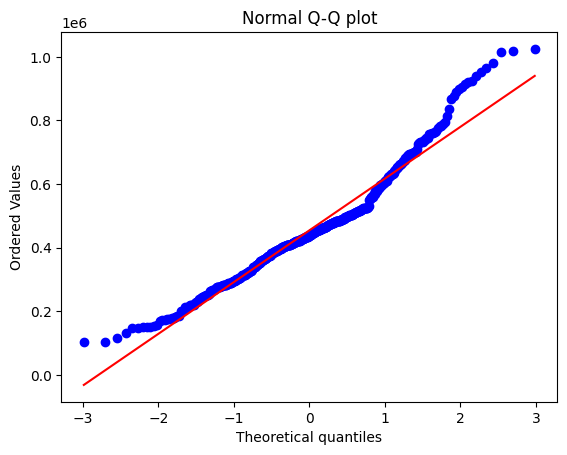

In [8]:
probplot(df.MEDV,dist='norm',plot=plt)
plt.style.use('dark_background')
plt.title('Normal Q-Q plot')
plt.show()

In [9]:
df.columns

Index(['RM', 'LSTAT', 'PTRATIO', 'MEDV'], dtype='object')

In [10]:
fig1 = px.histogram(df,x='MEDV',nbins=50,template='plotly_dark')
fig1.update_layout(title_text='Média dos valores')
fig1.show()

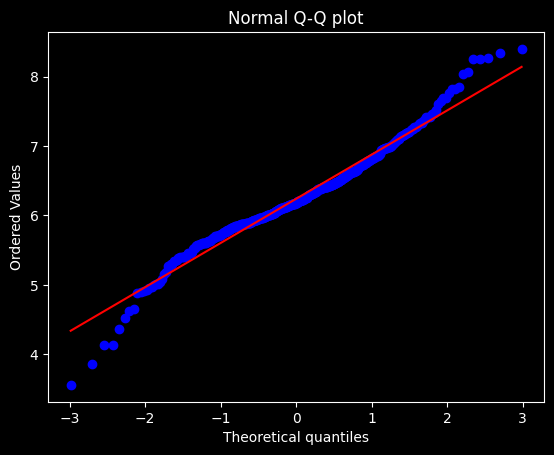

In [11]:
probplot(df.RM,dist='norm',plot=plt)
plt.style.use('dark_background')
plt.title('Normal Q-Q plot')
plt.show()

In [12]:
fig2 = px.histogram(df,x='RM',nbins=60,template='plotly_dark')
fig2.update_layout(title_text='Média dos quartos')
fig2.show()

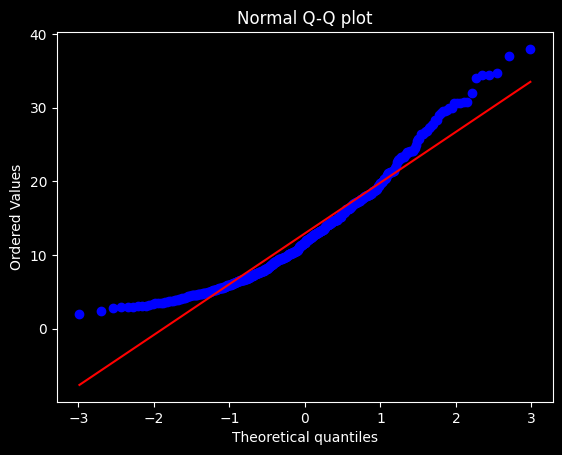

In [13]:
probplot(df.LSTAT,dist='norm',plot=plt)
plt.style.use('dark_background')
plt.title('Normal Q-Q plot')
plt.show()

In [14]:
fig3 = px.histogram(df,x='LSTAT', nbins=40,template='plotly_dark')
fig3.update_layout(title_text='Porcentagem de moradores de classe baixa')
fig3.show()

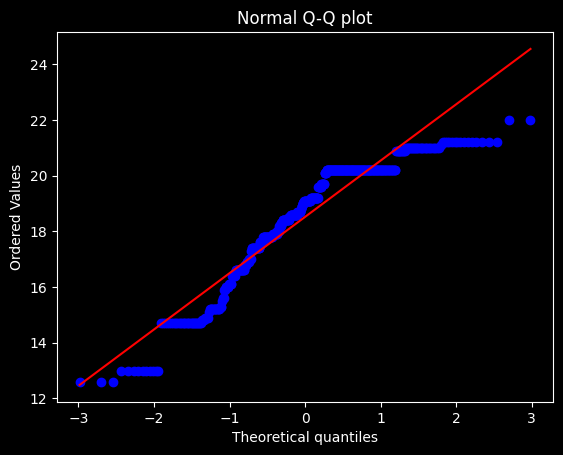

In [15]:
probplot(df.PTRATIO,dist='norm',plot=plt)
plt.style.use('dark_background')
plt.title('Normal Q-Q plot')
plt.show()

In [16]:
fig4 = px.histogram(df,x='PTRATIO',nbins=60,template='plotly_dark')
fig4.update_layout(title_text='Razão entre estudante e professores')
fig4.show()

##Teste de Shapiro-Wilk
Shapiro-Wilk pode ser usado no maximo 5000 linhas

Ho = distribuição normal: p > 0.05

Ha = distribuição != normal: p <= 0.05

In [17]:
shapiro(df.MEDV)

ShapiroResult(statistic=0.9596619009971619, pvalue=2.5762864064304836e-10)

In [18]:
estatistica,p =shapiro(df.MEDV)
print('Shapiro-Wilk')
print(f'Estatisca do teste: {round(estatistica,2)}')
print(f'P-valor: {p}')

Shapiro-Wilk
Estatisca do teste: 0.96
P-valor: 2.5762864064304836e-10


In [19]:
estatistica,p =shapiro(df.RM)
print('Shapiro-Wilk')
print(f'Estatisca do teste: {round(estatistica,2)}')
print(f'P-valor: {p}')

Shapiro-Wilk
Estatisca do teste: 0.97
P-valor: 2.7085933496096004e-08


In [20]:
estatistica,p =shapiro(df.LSTAT)
print('Shapiro-Wilk')
print(f'Estatisca do teste: {round(estatistica,2)}')
print(f'P-valor: {p}')

Shapiro-Wilk
Estatisca do teste: 0.94
P-valor: 1.6900520425407878e-13


In [21]:
estatistica,p =shapiro(df.PTRATIO)
print('Shapiro-Wilk')
print(f'Estatisca do teste: {round(estatistica,2)}')
print(f'P-valor: {p}')

Shapiro-Wilk
Estatisca do teste: 0.91
P-valor: 9.07583957756611e-17


## **Resultado:**
###Não a distribuição normal

--------

# **Teste lilliefors (Kolmogorov_Sminov)**
##Lilliefors pode ser usado com mais de 5000 linhas

Ho = distribuição normal: p > 0.05

Ha = distribuição normal: p<= 0.05

In [22]:
estatistica,p =statsmodels.stats.diagnostic.lilliefors(df.MEDV,dist='norm')
print('Lilliefors')
print(f'Estatisca do teste: {round(estatistica,2)}')
print(f'P-valor: {p}')

Lilliefors
Estatisca do teste: 0.11
P-valor: 0.0009999999999998899


In [23]:
estatistica,p =statsmodels.stats.diagnostic.lilliefors(df.RM,dist='norm')
print('Lilliefors')
print(f'Estatisca do teste: {round(estatistica,2)}')
print(f'P-valor: {p}')

Lilliefors
Estatisca do teste: 0.06
P-valor: 0.0009999999999998899


In [24]:
estatistica,p =statsmodels.stats.diagnostic.lilliefors(df.LSTAT,dist='norm')
print('Lilliefors')
print(f'Estatisca do teste: {round(estatistica,2)}')
print(f'P-valor: {p}')

Lilliefors
Estatisca do teste: 0.09
P-valor: 0.0009999999999998899


In [25]:
estatistica,p =statsmodels.stats.diagnostic.lilliefors(df.PTRATIO,dist='norm')
print('Lilliefors')
print(f'Estatisca do teste: {round(estatistica,2)}')
print(f'P-valor: {p}')

Lilliefors
Estatisca do teste: 0.18
P-valor: 0.0009999999999998899


## **Resultado:**
###Confirmação que não a distribuição normal

--------

# **Correlação Linear**
##Pearson (distribuição normal)

##Spearman (distribuição não normal)

##Kendall (distribuição não normal com quantidade pequena de amostras)

Ho = Não há correlação linear: p > 0.05

Ha = existe correlação linear: p <= 0.05

###**Pearson**

In [26]:
coef,p = pearsonr(df.MEDV,df.RM)
print('Pearson')
print(f'Coeficiente de correlação: {coef}')
print(f'p-valor: {p}')

Pearson
Coeficiente de correlação: 0.6972092210185156
p-valor: 2.0533141149513303e-72


### **Spearman**

In [27]:
coef,p = spearmanr(df.MEDV,df.RM)
print('Spearman')
print(f'Coeficiente de correlação: {coef}')
print(f'p-valor: {p}')

Spearman
Coeficiente de correlação: 0.6240572939087418
p-valor: 3.845028634343325e-54


### **Kendall**

In [28]:
coef,p = kendalltau(df.MEDV,df.RM)
print('Kendall')
print(f'Coeficiente de correlação: {coef}')
print(f'p-valor: {p}')

Kendall
Coeficiente de correlação: 0.4724931551110662
p-valor: 9.983146011545424e-55


In [29]:
correlacoes = df.corr(method='spearman')
correlacoes

,RM,LSTAT,PTRATIO,MEDV
RM,1.000000,-0.624700,-0.282053,0.624057
LSTAT,-0.624700,1.000000,0.461739,-0.845527
PTRATIO,-0.282053,0.461739,1.000000,-0.559276
MEDV,0.624057,-0.845527,-0.559276,1.000000


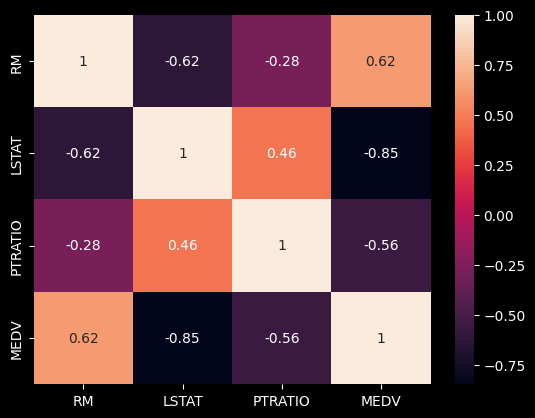

In [30]:
plt.figure()
sns.heatmap(correlacoes,annot=True)
sns.set_theme(style='darkgrid')

# **Regressão Linear Simples**

##Valor médio (MEDV) em função do número de cômodos (RM)

In [31]:
df.head(2)

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0


### Separando a coluna LSTAT

In [32]:
x1 = df.iloc[:,0:1].values
x1

array([[6.575],
       [6.421],
       [7.185],
       [6.998],
       [7.147],
       [6.43 ],
       [6.012],
       [6.172],
       [5.631],
       [6.004],
       [6.377],
       [6.009],
       [5.889],
       [5.949],
       [6.096],
       [5.834],
       [5.935],
       [5.99 ],
       [5.456],
       [5.727],
       [5.57 ],
       [5.965],
       [6.142],
       [5.813],
       [5.924],
       [5.599],
       [5.813],
       [6.047],
       [6.495],
       [6.674],
       [5.713],
       [6.072],
       [5.95 ],
       [5.701],
       [6.096],
       [5.933],
       [5.841],
       [5.85 ],
       [5.966],
       [6.595],
       [7.024],
       [6.77 ],
       [6.169],
       [6.211],
       [6.069],
       [5.682],
       [5.786],
       [6.03 ],
       [5.399],
       [5.602],
       [5.963],
       [6.115],
       [6.511],
       [5.998],
       [5.888],
       [7.249],
       [6.383],
       [6.816],
       [6.145],
       [5.927],
       [5.741],
       [5.966],
       [

### Separando as colunas alvo

In [33]:
y = df.iloc[:,3].values
y

array([ 504000.,  453600.,  728700.,  701400.,  760200.,  602700.,
        480900.,  569100.,  346500.,  396900.,  315000.,  396900.,
        455700.,  428400.,  382200.,  417900.,  485100.,  367500.,
        424200.,  382200.,  285600.,  411600.,  319200.,  304500.,
        327600.,  291900.,  348600.,  310800.,  386400.,  441000.,
        266700.,  304500.,  277200.,  275100.,  283500.,  396900.,
        420000.,  441000.,  518700.,  646800.,  732900.,  558600.,
        531300.,  518700.,  445200.,  405300.,  420000.,  348600.,
        302400.,  407400.,  413700.,  430500.,  525000.,  491400.,
        396900.,  743400.,  518700.,  663600.,  489300.,  411600.,
        392700.,  336000.,  466200.,  525000.,  693000.,  493500.,
        407400.,  462000.,  365400.,  438900.,  508200.,  455700.,
        478800.,  491400.,  506100.,  449400.,  420000.,  436800.,
        445200.,  426300.,  588000.,  501900.,  520800.,  480900.,
        501900.,  558600.,  472500.,  466200.,  495600.,  6027

### Separando os dados em teste e treino

In [34]:
x_treino,x_teste,y_treino,y_teste = train_test_split(x1,y, test_size=0.3, random_state=10,)

In [35]:
x_treino.shape,y_treino.shape

((342, 1), (342,))

In [36]:
x_teste.shape,y_teste.shape

((147, 1), (147,))

In [37]:
reg_linear1 = LinearRegression()
reg_linear1.fit(x_treino,y_treino)

LinearRegression()

### Intercepto (coeficiente linear)

In [38]:
reg_linear1.intercept_

-626510.2699464143

### Coeficiente Angular

In [39]:
reg_linear1.coef_

array([173771.45170999])

###**Equação: Valor = -626510.26 + 173771.45 vezes o número cômodos**

### Coeficiente de Determinação dados de treino

In [40]:
reg_linear1.score(x_treino,y_treino)

0.46368351515551953

In [41]:
reg_linear1.score(x_teste,y_teste)

0.5426573915930195

In [42]:
previsoes_treino = reg_linear1.predict(x_treino)
previsoes_treino

array([551833.94409904, 468423.64727824, 647755.78544295, 658182.07254555,
       586414.46298932, 464600.67534062, 395265.86610833, 229487.901177  ,
       441141.52935977, 424980.78435074, 523161.65456689, 432105.41387085,
       555135.60168153,  44768.84800928, 504915.65213734, 424285.6985439 ,
       565735.66023583, 607962.12300136, 455912.10275512, 442531.70097345,
       505784.50939589, 450003.87339698, 410210.21095539, 390226.49400874,
       472767.93357099, 809884.54988837, 401174.09546647, 639762.29866429,
       465817.07550259, 491882.79325909, 437318.55742215, 416813.52612037,
       413164.32563446, 560870.05958796, 396134.72336688, 459561.30324103,
       335488.4867201 , 521423.94004979, 441315.30081148, 630899.95462708,
       452262.90226921, 557915.94490889, 437144.78597044, 391616.66562242,
       525420.68343912, 459735.07469274, 397872.43788398, 492925.42196935,
       387619.92223309, 533240.39876607, 487538.50696634, 608483.43735649,
       832822.38151409, 4

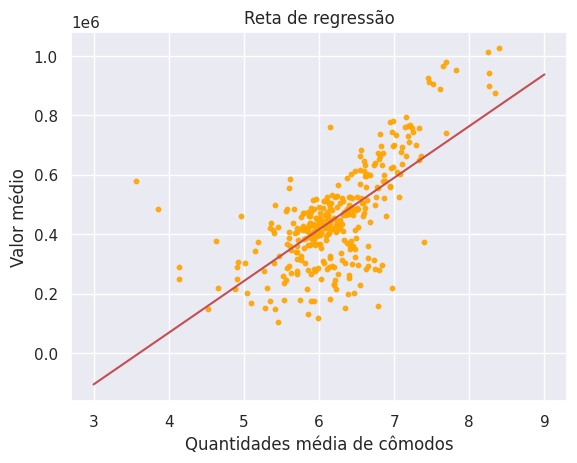

In [43]:
plt.scatter(y=y_treino,x=x_treino,color='orange', s=10, alpha=0.9)
x_plot = np.linspace(3,9)
plt.plot(x_plot,x_plot*reg_linear1.coef_ + reg_linear1.intercept_,color='r')
plt.style.use('dark_background')
plt.title('Reta de regressão')
plt.ylabel('Valor médio')
plt.xlabel('Quantidades média de cômodos')
plt.show()

In [44]:
previsoes_teste = reg_linear1.predict(x_teste)
previsoes_teste

array([419593.86934773, 438187.4146807 , 447744.84452475, 480935.19180136,
       491013.93600054, 494836.90793816, 563650.40281531, 438187.4146807 ,
       500745.1372963 , 482151.59196333, 452436.67372092, 452784.21662434,
       585719.37718248, 394744.5517532 , 321239.22767988, 442705.47242516,
       458171.13162735, 446702.21581449, 442357.92952174, 488581.1356766 ,
       592322.69234746, 244432.24602406, 412816.78273104, 540365.02828618,
       421331.58386483, 554092.97297127, 470856.44760218, 369373.91980354,
       732382.48242572, 411947.92547249, 484758.16373898, 514646.8534331 ,
       565561.88878412, 438534.95758412, 661483.73012804, 452957.98807605,
       579984.91927605, 402911.80998357, 351475.46027742, 537063.37070369,
       491535.25035567, 490145.07874199, 637503.26979206, 512735.36746429,
       722825.05258167, 631768.81188563, 489971.30729028, 353039.40334281,
       471551.53340902, 466512.16130943, 446007.13000765, 384492.03610231,
       390747.80836387, 3

In [45]:
y_teste

array([ 487200.,  428400.,  525000.,  483000.,  516600.,  462000.,
        592200.,  476700.,  512400.,  275100.,  487200.,  518700.,
        501900.,  499800.,  319200.,  621600.,  483000.,  445200.,
        373800.,  273000.,  644700.,  321300.,  510300.,  478800.,
        348600.,  462000.,  516600.,  405300.,  919800.,  266700.,
        455700.,  499800.,  627900.,  357000.,  665700.,  373800.,
        867300.,  327600.,  327600.,  501900.,  151200.,  499800.,
        726600.,  625800.,  835800.,  686700.,  338100.,  300300.,
        499800.,  493500.,  569100.,  220500.,  226800.,  411600.,
        478800.,  241500.,  655200.,  432600.,  441000.,  405300.,
        462000.,  252000.,  495600.,  577500.,  512400.,  392700.,
        279300.,  480900.,  497700.,  554400.,  399000.,  369600.,
        315000.,  445200.,  585900.,  105000.,  388500.,  453600.,
        312900.,  336000.,  315000.,  501900.,  323400.,  476700.,
        382200.,  609000.,  390600.,  413700.,  426300.,  2835

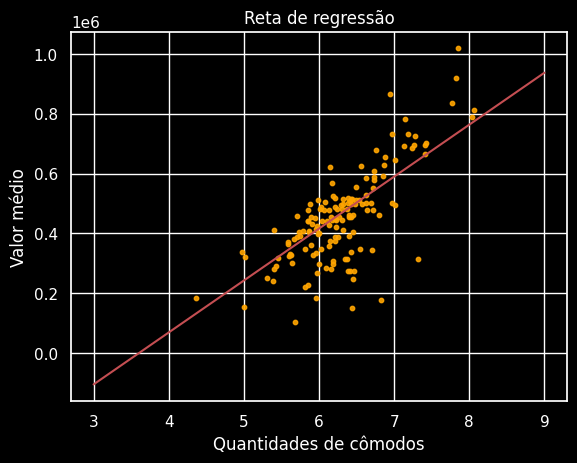

In [46]:
plt.scatter(y=y_teste,x=x_teste, color='orange', s=10, alpha=0.9)
x_plot = np.linspace(3,9)
plt.plot(x_plot,x_plot*reg_linear1.coef_ + reg_linear1.intercept_,color='r')
plt.style.use('dark_background')
plt.title('Reta de regressão')
plt.ylabel('Valor médio')
plt.xlabel('Quantidades de cômodos')
plt.show()

### Fazendo previsões para valores distintos

In [47]:
valor_casa =reg_linear1.predict([[9]])
valor_casa

array([937432.79544351])

## **Resposta:**

###Coeficiente esta muito baixo, isso esta causando erro na previsão dos valores das casas.

###Esta dando erro nas previsão de casas com 1 à 3 quartos.
------------

# **Métricas de Desempenho**

### Erro absoluto

In [48]:
abs(y_teste - previsoes_teste).mean()

76063.99733079868

### Erro médio absoluto

In [49]:
mean_absolute_error(y_teste,previsoes_teste)

76063.99733079868

### Erro quadrádico médio

In [50]:
mean_squared_error(y_teste,previsoes_teste)

11294624525.740473

### Raiz do erro quadrático médio

In [51]:
np.sqrt(mean_squared_error(y_teste,previsoes_teste))

106276.17101561607

### **Valor médio (MEDV) em função da classe social (RM)**

In [52]:
df.head(2)

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0


### Separando a coluna (RM)

In [53]:
x2 = df.iloc[:,0:1]

### Separando a coluna alvo (MEDV)

In [54]:
y = df.iloc[:,3].values

### Preparando os dados treino e teste

In [55]:
x_treino,x_teste,y_treino,y_teste = train_test_split(x2,y,test_size=0.3,random_state=10)


In [56]:
x_treino.shape,y_treino.shape

((342, 1), (342,))

In [57]:
x_teste.shape,y_teste.shape

((147, 1), (147,))

### Treinando o modelo

In [58]:
reg_linear2 = LinearRegression()
reg_linear2.fit(x_treino,y_treino)

LinearRegression()

### Intercepto (coeficinte linear)

In [59]:
reg_linear2.intercept_

-626510.2699464143

### Coeficiente Angular

In [60]:
reg_linear2.coef_

array([173771.45170999])

### **Equação: Valor = -626510.26 + 173771.45 x LSTAT(Números de cômodos)**

### Coeficiente de Determinacão dados de treino

In [61]:
reg_linear2.score(x_treino,y_treino)

0.46368351515551953

### Coeficiente de Determinacão dados de teste

In [62]:
reg_linear2.score(x_teste,y_teste)

0.5426573915930195

### Previsão

In [63]:
previsoes_treino1 = reg_linear2.predict(x_treino)
previsoes_treino1

array([551833.94409904, 468423.64727824, 647755.78544295, 658182.07254555,
       586414.46298932, 464600.67534062, 395265.86610833, 229487.901177  ,
       441141.52935977, 424980.78435074, 523161.65456689, 432105.41387085,
       555135.60168153,  44768.84800928, 504915.65213734, 424285.6985439 ,
       565735.66023583, 607962.12300136, 455912.10275512, 442531.70097345,
       505784.50939589, 450003.87339698, 410210.21095539, 390226.49400874,
       472767.93357099, 809884.54988837, 401174.09546647, 639762.29866429,
       465817.07550259, 491882.79325909, 437318.55742215, 416813.52612037,
       413164.32563446, 560870.05958796, 396134.72336688, 459561.30324103,
       335488.4867201 , 521423.94004979, 441315.30081148, 630899.95462708,
       452262.90226921, 557915.94490889, 437144.78597044, 391616.66562242,
       525420.68343912, 459735.07469274, 397872.43788398, 492925.42196935,
       387619.92223309, 533240.39876607, 487538.50696634, 608483.43735649,
       832822.38151409, 4

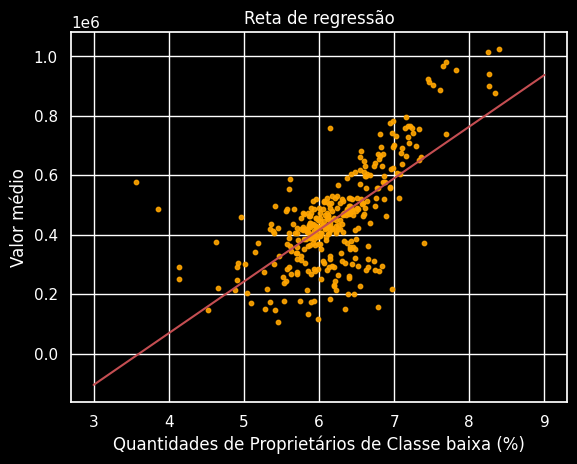

In [64]:
plt.scatter(y=y_treino,x=x_treino, color='orange', s=10, alpha=0.9)
x_plot = np.linspace(3,9)
plt.plot(x_plot,x_plot*reg_linear2.coef_ + reg_linear2.intercept_,color='r')
plt.style.use('dark_background')
plt.title('Reta de regressão')
plt.ylabel('Valor médio')
plt.xlabel('Quantidades de Proprietários de Classe baixa (%)')
plt.show()

In [65]:
# Prevendo os dados de teste
previsoes_teste = reg_linear2.predict(x_teste)
previsoes_teste

array([419593.86934773, 438187.4146807 , 447744.84452475, 480935.19180136,
       491013.93600054, 494836.90793816, 563650.40281531, 438187.4146807 ,
       500745.1372963 , 482151.59196333, 452436.67372092, 452784.21662434,
       585719.37718248, 394744.5517532 , 321239.22767988, 442705.47242516,
       458171.13162735, 446702.21581449, 442357.92952174, 488581.1356766 ,
       592322.69234746, 244432.24602406, 412816.78273104, 540365.02828618,
       421331.58386483, 554092.97297127, 470856.44760218, 369373.91980354,
       732382.48242572, 411947.92547249, 484758.16373898, 514646.8534331 ,
       565561.88878412, 438534.95758412, 661483.73012804, 452957.98807605,
       579984.91927605, 402911.80998357, 351475.46027742, 537063.37070369,
       491535.25035567, 490145.07874199, 637503.26979206, 512735.36746429,
       722825.05258167, 631768.81188563, 489971.30729028, 353039.40334281,
       471551.53340902, 466512.16130943, 446007.13000765, 384492.03610231,
       390747.80836387, 3

In [66]:
# Analisando o score
reg_linear2.score(x_teste,y_teste)

0.5426573915930195

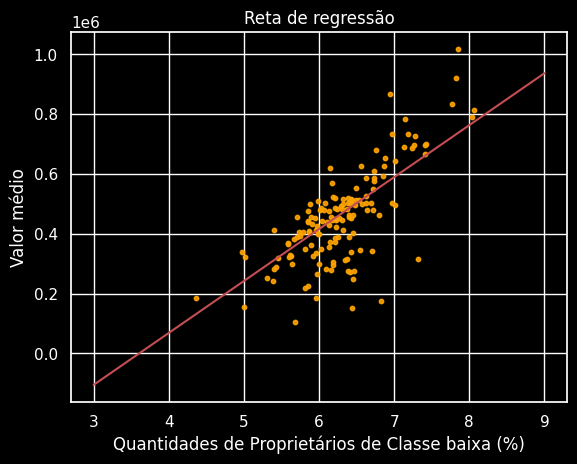

In [67]:
plt.scatter(y=y_teste,x=x_teste, color='orange', s=10, alpha=0.9)
x_plot = np.linspace(3,9)
plt.plot(x_plot,x_plot*reg_linear2.coef_ + reg_linear2.intercept_,color='r')
plt.style.use('dark_background')
plt.title('Reta de regressão')
plt.ylabel('Valor médio')
plt.xlabel('Quantidades de Proprietários de Classe baixa (%)')
plt.show()

In [68]:
# Fazendo previsões para valores distintos
valor_casa = reg_linear2.predict([[4]])
valor_casa

array([68575.53689355])

### Métricas de Desempenho

In [69]:
# Erro absoluto
abs(y_teste - previsoes_teste).mean()

76063.99733079868

In [70]:
# Erro médio absoluto
mean_absolute_error(y_teste, previsoes_teste)

76063.99733079868

In [71]:
# Erro quadrático médio
mean_squared_error(y_teste, previsoes_teste)

11294624525.740473

In [72]:
# Raiz do erro quadrático médio
np.sqrt(mean_squared_error(y_teste, previsoes_teste))

106276.17101561607

# Valor médio (MEDV) em função da classe social (LSTAT)

In [73]:
df.head(3)

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0


### Separando a coluna LSTAT

In [74]:
x3 = df.iloc[:,1:2].values
x3

array([[ 4.98],
       [ 9.14],
       [ 4.03],
       [ 2.94],
       [ 5.33],
       [ 5.21],
       [12.43],
       [19.15],
       [29.93],
       [17.1 ],
       [20.45],
       [13.27],
       [15.71],
       [ 8.26],
       [10.26],
       [ 8.47],
       [ 6.58],
       [14.67],
       [11.69],
       [11.28],
       [21.02],
       [13.83],
       [18.72],
       [19.88],
       [16.3 ],
       [16.51],
       [14.81],
       [17.28],
       [12.8 ],
       [11.98],
       [22.6 ],
       [13.04],
       [27.71],
       [18.35],
       [20.34],
       [ 9.68],
       [11.41],
       [ 8.77],
       [10.13],
       [ 4.32],
       [ 1.98],
       [ 4.84],
       [ 5.81],
       [ 7.44],
       [ 9.55],
       [10.21],
       [14.15],
       [18.8 ],
       [30.81],
       [16.2 ],
       [13.45],
       [ 9.43],
       [ 5.28],
       [ 8.43],
       [14.8 ],
       [ 4.81],
       [ 5.77],
       [ 3.95],
       [ 6.86],
       [ 9.22],
       [13.15],
       [14.44],
       [

### Separando coluna alvo (MEDV)

In [75]:
y = df.iloc[:,3].values
y

array([ 504000.,  453600.,  728700.,  701400.,  760200.,  602700.,
        480900.,  569100.,  346500.,  396900.,  315000.,  396900.,
        455700.,  428400.,  382200.,  417900.,  485100.,  367500.,
        424200.,  382200.,  285600.,  411600.,  319200.,  304500.,
        327600.,  291900.,  348600.,  310800.,  386400.,  441000.,
        266700.,  304500.,  277200.,  275100.,  283500.,  396900.,
        420000.,  441000.,  518700.,  646800.,  732900.,  558600.,
        531300.,  518700.,  445200.,  405300.,  420000.,  348600.,
        302400.,  407400.,  413700.,  430500.,  525000.,  491400.,
        396900.,  743400.,  518700.,  663600.,  489300.,  411600.,
        392700.,  336000.,  466200.,  525000.,  693000.,  493500.,
        407400.,  462000.,  365400.,  438900.,  508200.,  455700.,
        478800.,  491400.,  506100.,  449400.,  420000.,  436800.,
        445200.,  426300.,  588000.,  501900.,  520800.,  480900.,
        501900.,  558600.,  472500.,  466200.,  495600.,  6027

### Separando dados treino e teste

In [76]:
x_treino,x_teste,y_treino,y_teste = train_test_split(x3, y, test_size = 0.3, random_state=10)

In [77]:
x_treino.shape, y_treino.shape

((342, 1), (342,))

In [78]:
x_teste.shape, y_teste.shape

((147, 1), (147,))

### Treinando o modelo

In [79]:
reg_linear3 = LinearRegression()
reg_linear3.fit(x_treino,y_treino)

LinearRegression()

### Intercepto (coeficiente linear)

In [80]:
reg_linear3.intercept_

681977.7451055486

### Coeficiente Angular

In [81]:
reg_linear3.coef_

array([-17263.75010515])

### **Equação: Valor = 681977.74 - 17263.75 x LSTAT(Números de cômodos)**

### Coeficiente de Determinação dados de treino

In [82]:
reg_linear3.score(x_treino,y_treino)

0.5688289563355992

In [83]:
previsoes_treino = reg_linear3.predict(x_treino)
previsoes_treino

array([549564.78179906, 401787.080899  , 547493.13178645, 392982.56834537,
       594968.4445756 , 475330.65634693, 474294.83134062, 172179.20450053,
       525050.25664975, 358109.79313297, 527812.45666658, 386940.25580857,
       595141.08207665, 451851.95620393, 590825.14455037, 383660.14328859,
       624489.45725541, 543004.55675911, 413526.4309705 , 422676.21852623,
       572180.29443681, 457548.99373862, 507095.9565404 , 397643.78087376,
       492594.40645207, 610505.81967024, 365533.20567819, 611541.64467654,
       527639.81916553, 401959.71840005, 578740.51947676, 435624.03110509,
       370021.78070552, 342054.50553518, 530229.3816813 , 587027.11952723,
       274553.24262406, 554743.90683061, 563548.41938423, 562339.95687687,
       420086.65601045, 613785.93219021, 536271.6942181 , 515555.19409192,
       280250.28015875, 437005.1311135 , 499672.54399519, 541105.54424754,
       359836.16814349, 475158.01884588, 422676.21852623, 533336.85670022,
       579948.98198412, 5

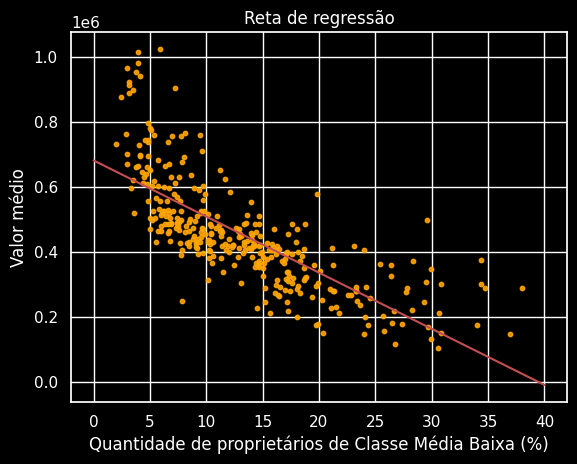

In [84]:
plt.scatter(y=y_treino,x=x_treino, color="orange", s=10, alpha=0.9)
x_plot = np.linspace(0,40)
plt.plot(x_plot, x_plot*reg_linear3.coef_+reg_linear3.intercept_, color='r')
plt.title('Reta de regressão')
plt.ylabel('Valor médio')
plt.xlabel('Quantidade de proprietários de Classe Média Baixa (%)')
plt.show()

In [85]:
previsoes_teste = reg_linear3.predict(x_teste)
previsoes_teste

array([507441.2315425 , 438731.50612401, 518490.0316098 , 500708.36900149,
       594277.8945714 , 539897.08174018, 551981.70681378, 483789.89389845,
       580121.61948518, 272999.50511459, 558714.56935479, 553535.44432325,
       584610.19451251, 472395.81882905, 370194.41820658, 454959.43122285,
       496565.06897626, 474122.19383957, 363288.91816452, 348614.73057514,
       426646.88105041, 472741.09383115, 480855.05638057, 506578.04403724,
       357419.24312877, 570108.64442419, 573388.75694417, 447018.10617448,
       620346.15723017, 353793.85560668, 452887.78121023, 521770.14412977,
       562512.59437792, 420949.84351571, 591343.05705352, 378135.74325494,
       602737.13212292, 400578.61839164, 394536.30585483, 558024.01935059,
       180465.804551  , 557678.74434848, 567691.71940947, 603255.04462607,
       551463.79431063, 587199.75702829, 474294.83134062, 365360.56817713,
       490350.11893841, 601356.03211451, 351376.93059196, 300276.23028073,
       271273.13010408, 4

In [86]:
y_teste

array([ 487200.,  428400.,  525000.,  483000.,  516600.,  462000.,
        592200.,  476700.,  512400.,  275100.,  487200.,  518700.,
        501900.,  499800.,  319200.,  621600.,  483000.,  445200.,
        373800.,  273000.,  644700.,  321300.,  510300.,  478800.,
        348600.,  462000.,  516600.,  405300.,  919800.,  266700.,
        455700.,  499800.,  627900.,  357000.,  665700.,  373800.,
        867300.,  327600.,  327600.,  501900.,  151200.,  499800.,
        726600.,  625800.,  835800.,  686700.,  338100.,  300300.,
        499800.,  493500.,  569100.,  220500.,  226800.,  411600.,
        478800.,  241500.,  655200.,  432600.,  441000.,  405300.,
        462000.,  252000.,  495600.,  577500.,  512400.,  392700.,
        279300.,  480900.,  497700.,  554400.,  399000.,  369600.,
        315000.,  445200.,  585900.,  105000.,  388500.,  453600.,
        312900.,  336000.,  315000.,  501900.,  323400.,  476700.,
        382200.,  609000.,  390600.,  413700.,  426300.,  2835

### Coeficiente de Determinação dados de teste

In [87]:
reg_linear3.score(x_teste,y_teste)

0.6006038196307664

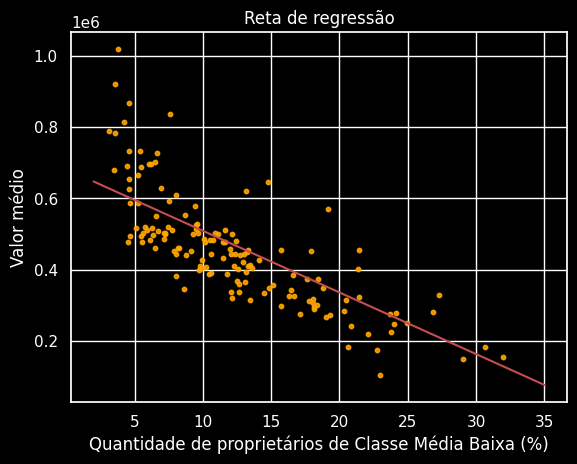

In [88]:
plt.scatter(y=y_teste,x=x_teste, color="orange", s=10, alpha=0.9)
x_plot = np.linspace(2,35)
plt.plot(x_plot, x_plot*reg_linear3.coef_+reg_linear3.intercept_, color='r')
plt.title('Reta de regressão')
plt.ylabel('Valor médio')
plt.xlabel('Quantidade de proprietários de Classe Média Baixa (%)')
plt.show()

In [89]:
# Fazendo previsões para valores distintos
valor_casa = reg_linear3.predict([[25]])
valor_casa

array([250383.99247685])

### Métricas de Desempenho

In [90]:
# Erro absoluto
abs(y_teste - previsoes_teste).mean()

76340.55192245146

In [91]:
# Erro médio Absoluto
mean_absolute_error(y_teste, previsoes_teste)

76340.55192245146

In [92]:
# Erro quadrático médio
mean_squared_error(y_teste, previsoes_teste)

9863567949.634668

In [93]:
# Raiz do erro quadrático médio (RMSE)
np.sqrt(mean_squared_error(y_teste, previsoes_teste))

99315.49702657017

### Validação Cruzada

In [94]:
# Separando os dados em folds
kfold = KFold(n_splits = 15, shuffle=True, random_state = 5)

In [95]:
# Criando o modelo
modelo = LinearRegression()
resultado = cross_val_score(modelo,x3,y,cv = kfold)
resultado

array([0.73997836, 0.52496442, 0.2753212 , 0.77336843, 0.7096672 ,
       0.34726472, 0.66194425, 0.68820343, 0.411042  , 0.5519506 ,
       0.5776707 , 0.37648029, 0.60443851, 0.64797086, 0.5056103 ])

In [96]:
# Usando a média e o desvio padrão
print(f'Coef.determinação média: {round(resultado.mean()*100.0,2)}%')

Coef.determinação média: 55.97%


### Avaliando a Regressão Linear Simples com Statsmodels

In [97]:
df.head(2)

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0


In [98]:
x = df.iloc[:,1:2].values

In [99]:
y = df.iloc[:,3].values

In [100]:
# Criando o modelo
regressao = smf.ols('y ~ x', data = df).fit()

In [101]:
residuos = regressao.resid
residuos

0      -91698.432398
1      -68220.791356
2      116130.471691
3       69473.109014
4      170717.234516
           ...      
484    -42008.495743
485    -90286.334256
486    -82077.460502
487   -107059.859907
488   -294297.192249
Length: 489, dtype: float64

## Teste de Normalidade dos resídos

### Ho = distribuição normal: p > 0.05

### Ha = distribuição != normal : p <= 0.05

In [102]:
estatistica, p = shapiro(residuos)
print('Shapiro-Wilk')
print(f'Estatítica de teste: {estatistica}')
print(f'p-valor: {p}')

Shapiro-Wilk
Estatítica de teste: 0.9171054363250732
p-valor: 9.782326333115975e-16


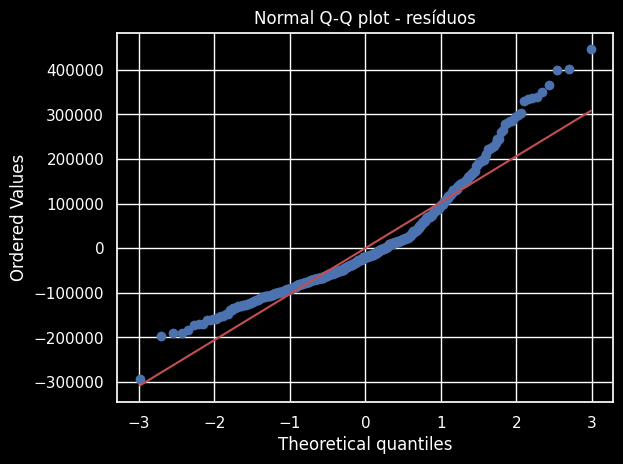

In [103]:
probplot(residuos, dist='norm', plot=plt)
plt.style.use('dark_background')
plt.title('Normal Q-Q plot - resíduos')
plt.show()

## **Análise da Homocedasticidade**

### (Resíduos com variação constante)

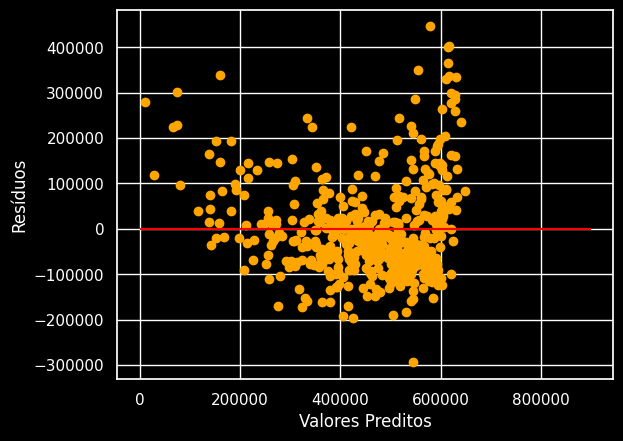

In [104]:
plt.scatter(y=residuos, x=regressao.predict(), color='orange')
plt.hlines(y=0, xmin=0, xmax=900000, color='red')
plt.ylabel('Resíduos')
plt.xlabel('Valores Preditos')
plt.show()

## Teste Breusch-Pagan (Homocedasticidade ou Heterocedasticidade)

### Ho = existe homocedasticidade: p > 0.05

### Ha = não existe homocedasticidade: p <= 0.05

In [105]:
estatistica, p, f, fp = sms.het_breuschpagan (regressao.resid, regressao.model.exog)
print('Teste Breusch-Pagan')
print(f'Estatística de teste: {estatistica}')
print(f'p-valor: {p}')
print(f'f-valor: {f}')
print(f'f_p-valor: {fp}')

Teste Breusch-Pagan
Estatística de teste: 5.3825533640267285
p-valor: 0.020339089399132346
f-valor: 5.420200421872106
f_p-valor: 0.020313692181464678


## **Outliers nos resíduos**
### (entre -3 e 3)

In [106]:
outliers = regressao.outlier_test()

In [107]:
outliers.max()

student_resid    4.227468
unadj_p          0.999732
bonf(p)          1.000000
dtype: float64

In [108]:
outliers.min()

student_resid   -2.762057
unadj_p          0.000028
bonf(p)          0.013809
dtype: float64

### Modelo não consistência
------

### **Modelo de Regressão Linear**

In [109]:
print(regressao.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     668.7
Date:                Wed, 29 May 2024   Prob (F-statistic):           1.93e-93
Time:                        19:00:35   Log-Likelihood:                -6357.8
No. Observations:                 489   AIC:                         1.272e+04
Df Residuals:                     487   BIC:                         1.273e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.841e+05   1.01e+04     67.551      0.0

### **Estatística t:**

Ho = coeficiente igual a zero: p> 0,05 (coeficiente não validado)

Ha = coeeficiente diferente de zero: p <= 0,05 (coeficiente validado)

**Rˆ2 ajustado = 0,578**

In [110]:
coefs = pd.DataFrame(regressao.params)
coefs.columns = ['Coeficientes']
print(coefs)

            Coeficientes
Intercept  684138.493068
x          -17759.048327


### **Equação: Valor = 684138,49 - 17759.04 x LSTAT**

In [111]:
regressao.params

Intercept    684138.493068
x            -17759.048327
dtype: float64

In [112]:
df.head()

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


In [113]:
regressao.predict()

array([595698.43239814, 521820.79135628, 612569.52830915, 631926.89098598,
       589482.76548356, 591613.85128285, 463393.52235923, 344052.7175993 ,
       152610.17663024, 380458.76667041, 320965.95477372, 448475.92176424,
       405143.84384545, 537448.75388437, 501930.65722963, 533719.35373562,
       567283.95507435, 423613.25410592, 476535.21812149, 483816.42793571,
       310843.29722712, 438530.85470091, 351689.10838007, 331088.61232032,
       394666.00533231, 390936.60518356, 421126.98734009, 377262.13797148,
       456822.6744781 , 471385.09410655, 282784.00086987, 452560.50287953,
       192035.26391701, 358259.9562612 , 322919.45008973, 512230.9052595 ,
       481507.75165315, 528391.63923741, 504239.33351218, 607419.40429421,
       648975.57738026, 598184.69916397, 580958.42228643, 552011.17351281,
       514539.58154206, 502818.60964599, 432847.95923615, 350268.38451388,
       136982.21410216, 396441.91016504, 445279.29306531, 516670.66734134,
       590370.71789993, 5

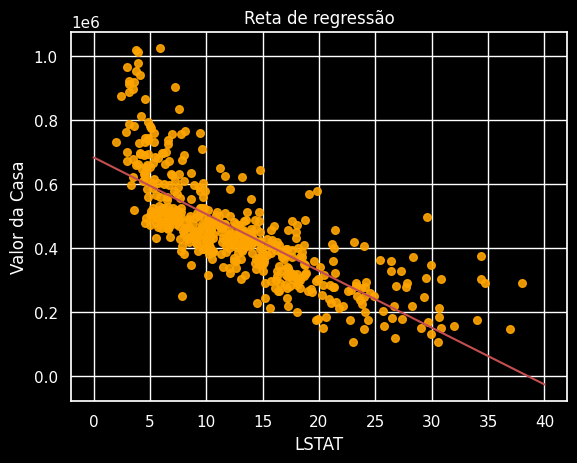

In [114]:
plt.scatter(y=df.MEDV,x=df.LSTAT, color="orange", s=30, alpha=0.9)
x_plot = np.linspace(0,40)
plt.plot(x_plot, x_plot*regressao.params[1]+regressao.params[0], color='r')
plt.title('Reta de regressão')
plt.ylabel('Valor da Casa')
plt.xlabel('LSTAT')
plt.show()

# **Regressão Linear Múltipla**

In [115]:
df.head(2)

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0


In [116]:
independente = df.iloc[:,0:3].values
independente

array([[ 6.575,  4.98 , 15.3  ],
       [ 6.421,  9.14 , 17.8  ],
       [ 7.185,  4.03 , 17.8  ],
       ...,
       [ 6.976,  5.64 , 21.   ],
       [ 6.794,  6.48 , 21.   ],
       [ 6.03 ,  7.88 , 21.   ]])

In [117]:
independente.shape

(489, 3)

In [118]:
dependente = df.iloc[:,3].values
dependente

array([ 504000.,  453600.,  728700.,  701400.,  760200.,  602700.,
        480900.,  569100.,  346500.,  396900.,  315000.,  396900.,
        455700.,  428400.,  382200.,  417900.,  485100.,  367500.,
        424200.,  382200.,  285600.,  411600.,  319200.,  304500.,
        327600.,  291900.,  348600.,  310800.,  386400.,  441000.,
        266700.,  304500.,  277200.,  275100.,  283500.,  396900.,
        420000.,  441000.,  518700.,  646800.,  732900.,  558600.,
        531300.,  518700.,  445200.,  405300.,  420000.,  348600.,
        302400.,  407400.,  413700.,  430500.,  525000.,  491400.,
        396900.,  743400.,  518700.,  663600.,  489300.,  411600.,
        392700.,  336000.,  466200.,  525000.,  693000.,  493500.,
        407400.,  462000.,  365400.,  438900.,  508200.,  455700.,
        478800.,  491400.,  506100.,  449400.,  420000.,  436800.,
        445200.,  426300.,  588000.,  501900.,  520800.,  480900.,
        501900.,  558600.,  472500.,  466200.,  495600.,  6027

In [119]:
x_treino,x_teste,y_treino,y_teste = train_test_split(independente,dependente, test_size = 0.3, random_state = 0)

In [120]:
x_treino.shape,x_teste.shape

((342, 3), (147, 3))

In [121]:
multipla = LinearRegression()
multipla.fit(x_treino, y_treino)

LinearRegression()

In [122]:
multipla.intercept_

434789.4550955225

In [123]:
multipla.coef_

array([ 85325.36412937, -10775.41479323, -20133.58779106])

### Coeficente de Determinação dos dados de treino

In [124]:
multipla.score(x_treino,y_treino)

0.7343049403294957

### Teste

In [125]:
previsoes = multipla.predict(x_teste)
previsoes

array([418504.52251533, 682498.59311161, 310842.03220354, 399602.67212048,
       529013.04970446, 364349.16756502, 241564.07559959, 413075.10184459,
       476051.89023052, 371925.92192458, 324382.18849665, 357068.87403347,
       472650.96518839,  52625.76046357, 486476.7874084 , 312653.08514703,
       465067.60969605, 614663.51972717, 383059.21254559, 653229.85415898,
       677008.34036381, 653364.33988067,  15201.46316315, 452877.56192735,
       360692.75896586, 754677.40725013, 714803.22773315, 754640.19558449,
       430756.93101727, 422579.57707332, 378309.3992427 , 461958.22362764,
       472103.18520444, 681780.56381622, 457070.41410848, 769207.31373834,
       520822.33816699, 261675.315203  , 503180.52774604, 590132.54786611,
       324624.03541901, 452521.53520288, 400704.94316867, 498314.39406844,
       280336.01343561, 365481.99718596, 525798.46427921, 361547.63013434,
       716795.14226269, 407424.79029782, 679886.98036124, 445827.68346551,
       614892.98134094, 3

### Coeficiente de Determinação dos dados de teste

In [126]:
multipla.score(x_teste,y_teste)

0.6817814124380092

### Fazendo previsões para o valores distintos

In [127]:
valor_casa = multipla.predict([[8,25,15]])
print(f'Valor do imóvel: {valor_casa}')

Valor do imóvel: [546003.18143388]


### **Métricas**

###Erro médio Absoluto

In [128]:
mean_absolute_error(y_teste, previsoes)

71651.46435650405

### Erro quadrático médio

In [129]:
mean_squared_error(y_teste, previsoes)

9232768512.15146

### Raiz do erro quadrático médio

In [130]:
np.sqrt(mean_squared_error(y_teste, previsoes))

96087.2963099257

## **Validação Cruzada**

### Separando os dados em folds

In [131]:
kfold = KFold(n_splits = 15, shuffle=True, random_state = 5)

### Criando o modelo

In [132]:
modelo = LinearRegression()
resultado = cross_val_score(modelo, independente, dependente, cv = kfold)
resultado

array([0.83061794, 0.77028683, 0.46606666, 0.81532627, 0.79492754,
       0.60625828, 0.82164061, 0.7750116 , 0.58744519, 0.74753069,
       0.76227037, 0.51253844, 0.71206526, 0.73425176, 0.45176491])

### Usando a média e o desvio padrão

In [133]:
print(f'Coeficiente de Determinação Médio : {round(resultado.mean() * 100,2)}%')

Coeficiente de Determinação Médio : 69.25%


### **Regressão Linear Simples:** Rˆ2 = 0,57/0,60; RMSE = 99315,5; Rˆ2 Validação Cruzada: 55,97%

### **Regressão Linear Múltipla:** Rˆ2 = 0,73/0,68; RMSE = 96087,3; Rˆ2 Validação Cruzada: 69,25%

# **Avaliando a Regressão Linear Múltipla com Statsmodels**

In [134]:
df.head(2)

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0


### Criação do modelo

In [135]:
modelo = smf.ols('MEDV ~ RM + LSTAT + PTRATIO', data = df).fit()

In [136]:
residuos = modelo.resid
residuos

0     -128371.739762
1      -71577.148313
2       81946.881920
3       76551.704130
4      148383.407464
           ...      
484     -1541.448492
485     -4797.202628
486    -46918.775678
487    -61950.456779
488   -192725.539836
Length: 489, dtype: float64

### Teste de Normalidade dos resíduos


### Ho = distribuição normal: p > 0.05

### Ha = distribuição != normal: p <= 0.05

In [137]:
estatistica, p = shapiro(residuos)
print(f'Estatística de teste: {estatistica}')
print(f'p_valor: {p}')

Estatística de teste: 0.9633496403694153
p_valor: 1.0875824685285806e-09


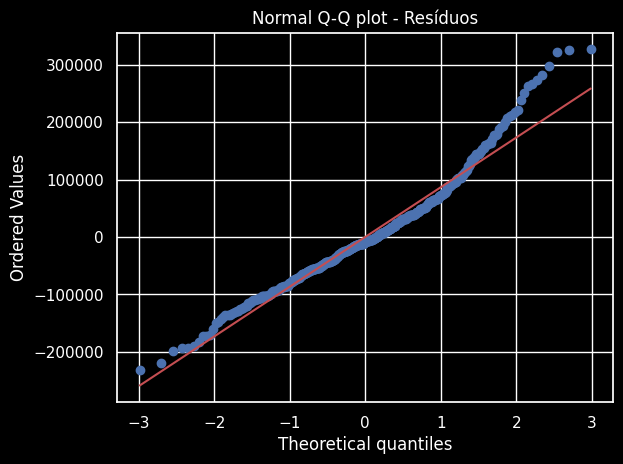

In [138]:
probplot(residuos, dist='norm', plot=plt)
plt.title('Normal Q-Q plot - Resíduos')
plt.show()

## **Análise da Homocedasticidade dos resíduos**
### (resíduos com variação constante)

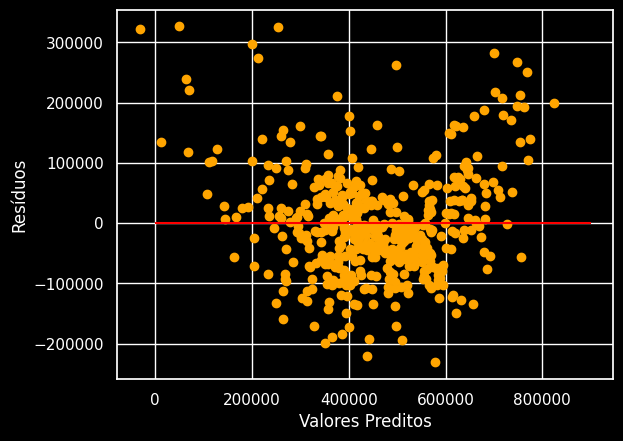

In [139]:
plt.scatter(y=residuos, x=modelo.predict(), color='orange')
plt.hlines(y=0, xmin=0, xmax=900000, color='red')
plt.ylabel('Resíduos')
plt.xlabel('Valores Preditos')
plt.show()

### Teste Breusch-Pagan (Homocedasticidade ou heterocedasticidade)

### Ho = ecxiste homocedasticidade: p > 0.05

### Ha = não existe homocedasticidade: p <= 0.05

In [140]:
estatistica, p, f, fp = sms.het_breuschpagan(modelo.resid, modelo.model.exog)
print(f'Estatística de teste: {estatistica}')
print(f'p-valor: {p}')
print(f'f-valor: {f}')
print(f'f_p-valor: {fp}')

Estatística de teste: 14.866517741157674
p-valor: 0.0019343456956172854
f-valor: 5.069079611723632
f_p-valor: 0.0018260051160026575


### **Outliers nos resíduos**

### (entre -3 e 3)

In [141]:
outliers = modelo.outlier_test()
outliers.max()

student_resid    3.887418
unadj_p          0.999502
bonf(p)          1.000000
dtype: float64

In [142]:
outliers.min()

student_resid   -2.648018
unadj_p          0.000115
bonf(p)          0.056456
dtype: float64

### **Ausência de Multicolinearidade**

### Somente entre as variáveis independentes.

### Considerada multicolinearidade quando r > 0.9

In [143]:
variaveis = df[["RM",'LSTAT','PTRATIO']]

In [144]:
variaveis.head()

,RM,LSTAT,PTRATIO
0,6.575,4.98,15.3
1,6.421,9.14,17.8
2,7.185,4.03,17.8
3,6.998,2.94,18.7
4,7.147,5.33,18.7


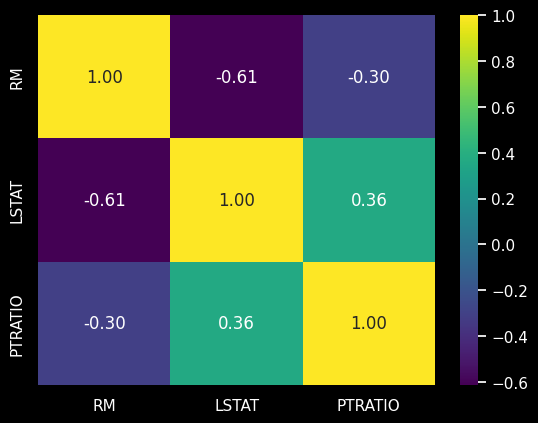

In [145]:
correlacoes = variaveis.corr(method='pearson')
sns.heatmap(correlacoes,annot=True, fmt=".2f", cmap='viridis');

### **Análise do modelo**

### Intercept

### p_valor para cada coeficiente < 0.05 (estatisticamente significativos).

### Ajusted R-squared (explicação do modelo através dos dados).

### p_valor da estatística f< 0.05 (valida o modelo de regressão).

In [146]:
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     410.9
Date:                Wed, 29 May 2024   Prob (F-statistic):          9.96e-133
Time:                        19:00:37   Log-Likelihood:                -6259.9
No. Observations:                 489   AIC:                         1.253e+04
Df Residuals:                     485   BIC:                         1.254e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.155e+05   6.88e+04      6.035      0.0

### **Equação:** Valorda casa = 4.155e+05.Itercept + 8.657e+04.RM - 1.085e+04.LSTAT - 1.949e+04.PTRATIO

### Criando uma coluna com previsão

In [147]:
df['previsao'] = modelo.fittedvalues

In [148]:
df.head()

,RM,LSTAT,PTRATIO,MEDV,previsao
0,6.575,4.98,15.3,504000.0,632371.739762
1,6.421,9.14,17.8,453600.0,525177.148313
2,7.185,4.03,17.8,728700.0,646753.118080
3,6.998,2.94,18.7,701400.0,624848.295870
4,7.147,5.33,18.7,760200.0,611816.592536


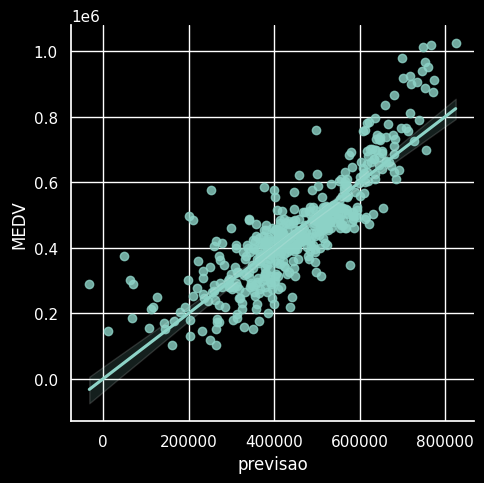

In [149]:
sns.lmplot(x='previsao', y='MEDV', data=df);

----

## **Regressão Polinomial**

### Valor médio (MEDV) em função do número de cômodos (RM)

In [150]:
df.head(2)

,RM,LSTAT,PTRATIO,MEDV,previsao
0,6.575,4.98,15.3,504000.0,632371.739762
1,6.421,9.14,17.8,453600.0,525177.148313


In [151]:
x = df.iloc[:,0:1].values
x

array([[6.575],
       [6.421],
       [7.185],
       [6.998],
       [7.147],
       [6.43 ],
       [6.012],
       [6.172],
       [5.631],
       [6.004],
       [6.377],
       [6.009],
       [5.889],
       [5.949],
       [6.096],
       [5.834],
       [5.935],
       [5.99 ],
       [5.456],
       [5.727],
       [5.57 ],
       [5.965],
       [6.142],
       [5.813],
       [5.924],
       [5.599],
       [5.813],
       [6.047],
       [6.495],
       [6.674],
       [5.713],
       [6.072],
       [5.95 ],
       [5.701],
       [6.096],
       [5.933],
       [5.841],
       [5.85 ],
       [5.966],
       [6.595],
       [7.024],
       [6.77 ],
       [6.169],
       [6.211],
       [6.069],
       [5.682],
       [5.786],
       [6.03 ],
       [5.399],
       [5.602],
       [5.963],
       [6.115],
       [6.511],
       [5.998],
       [5.888],
       [7.249],
       [6.383],
       [6.816],
       [6.145],
       [5.927],
       [5.741],
       [5.966],
       [

In [152]:
y = df.iloc[:,3].values
y

array([ 504000.,  453600.,  728700.,  701400.,  760200.,  602700.,
        480900.,  569100.,  346500.,  396900.,  315000.,  396900.,
        455700.,  428400.,  382200.,  417900.,  485100.,  367500.,
        424200.,  382200.,  285600.,  411600.,  319200.,  304500.,
        327600.,  291900.,  348600.,  310800.,  386400.,  441000.,
        266700.,  304500.,  277200.,  275100.,  283500.,  396900.,
        420000.,  441000.,  518700.,  646800.,  732900.,  558600.,
        531300.,  518700.,  445200.,  405300.,  420000.,  348600.,
        302400.,  407400.,  413700.,  430500.,  525000.,  491400.,
        396900.,  743400.,  518700.,  663600.,  489300.,  411600.,
        392700.,  336000.,  466200.,  525000.,  693000.,  493500.,
        407400.,  462000.,  365400.,  438900.,  508200.,  455700.,
        478800.,  491400.,  506100.,  449400.,  420000.,  436800.,
        445200.,  426300.,  588000.,  501900.,  520800.,  480900.,
        501900.,  558600.,  472500.,  466200.,  495600.,  6027

In [153]:
# Separando dados de treino e teste
x_treino,x_teste,y_treino,y_teste = train_test_split(x,y, test_size = 0.3, random_state = 0)

In [154]:
x_treino.shape, y_treino.shape

((342, 1), (342,))

In [155]:
x_teste.shape, y_teste.shape

((147, 1), (147,))

In [156]:
# Pré Processamento
grau_polinomial = PolynomialFeatures(degree=2)

In [157]:
x_poly = grau_polinomial.fit_transform(x_treino)
x_poly

array([[ 1.      ,  6.266   , 39.262756],
       [ 1.      ,  6.951   , 48.316401],
       [ 1.      ,  6.619   , 43.811161],
       ...,
       [ 1.      ,  6.021   , 36.252441],
       [ 1.      ,  6.03    , 36.3609  ],
       [ 1.      ,  6.02    , 36.2404  ]])

In [158]:
polinomial = LinearRegression()

In [159]:
polinomial.fit(x_poly, y_treino)

LinearRegression()

In [160]:
previsoes_treino = polinomial.predict(x_poly)

In [161]:
polinomial.coef_

array([      0.        , -568528.11104731,   60092.59048475])

In [162]:
polinomial.intercept_

1640107.0085836346

## **Equação:**

### Valor = 1640107 -568528.11xRM + 60092.59xRMˆ2

In [163]:
numeros = np.linspace(3,9.84,342)
numeros

array([3.        , 3.02005865, 3.0401173 , 3.06017595, 3.0802346 ,
       3.10029326, 3.12035191, 3.14041056, 3.16046921, 3.18052786,
       3.20058651, 3.22064516, 3.24070381, 3.26076246, 3.28082111,
       3.30087977, 3.32093842, 3.34099707, 3.36105572, 3.38111437,
       3.40117302, 3.42123167, 3.44129032, 3.46134897, 3.48140762,
       3.50146628, 3.52152493, 3.54158358, 3.56164223, 3.58170088,
       3.60175953, 3.62181818, 3.64187683, 3.66193548, 3.68199413,
       3.70205279, 3.72211144, 3.74217009, 3.76222874, 3.78228739,
       3.80234604, 3.82240469, 3.84246334, 3.86252199, 3.88258065,
       3.9026393 , 3.92269795, 3.9427566 , 3.96281525, 3.9828739 ,
       4.00293255, 4.0229912 , 4.04304985, 4.0631085 , 4.08316716,
       4.10322581, 4.12328446, 4.14334311, 4.16340176, 4.18346041,
       4.20351906, 4.22357771, 4.24363636, 4.26369501, 4.28375367,
       4.30381232, 4.32387097, 4.34392962, 4.36398827, 4.38404692,
       4.40410557, 4.42416422, 4.44422287, 4.46428152, 4.48434

In [164]:
numeros.shape

(342,)

In [165]:
valor = 1640107 -568528.11*numeros + 60092.59*numeros**2

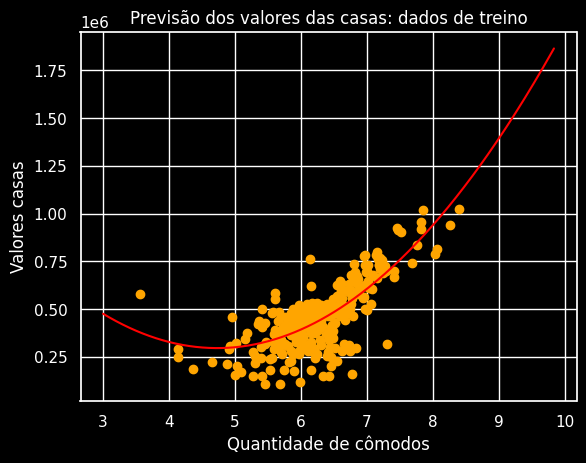

In [166]:
plt.scatter(x_treino,y_treino,c = 'orange')
plt.xlabel('Quantidade de cômodos')
plt.ylabel('Valores casas')
plt.title('Previsão dos valores das casas: dados de treino')
plt.plot(numeros,valor,color='red')
plt.show();

In [167]:
# Fazendo previsões para valores distintos
comodos = 6
valor = 1640107 -568528.11*comodos + 60092.59*comodos**2
valor

392271.5799999996

In [168]:
# Coeficiente de Determinação dados de treino
polinomial.score(x_poly,y_treino)

0.5864656525780776

### Teste

In [169]:
numeros1 = np.linspace(3,8.88,147)
numeros1

array([3.        , 3.04027397, 3.08054795, 3.12082192, 3.16109589,
       3.20136986, 3.24164384, 3.28191781, 3.32219178, 3.36246575,
       3.40273973, 3.4430137 , 3.48328767, 3.52356164, 3.56383562,
       3.60410959, 3.64438356, 3.68465753, 3.72493151, 3.76520548,
       3.80547945, 3.84575342, 3.8860274 , 3.92630137, 3.96657534,
       4.00684932, 4.04712329, 4.08739726, 4.12767123, 4.16794521,
       4.20821918, 4.24849315, 4.28876712, 4.3290411 , 4.36931507,
       4.40958904, 4.44986301, 4.49013699, 4.53041096, 4.57068493,
       4.6109589 , 4.65123288, 4.69150685, 4.73178082, 4.77205479,
       4.81232877, 4.85260274, 4.89287671, 4.93315068, 4.97342466,
       5.01369863, 5.0539726 , 5.09424658, 5.13452055, 5.17479452,
       5.21506849, 5.25534247, 5.29561644, 5.33589041, 5.37616438,
       5.41643836, 5.45671233, 5.4969863 , 5.53726027, 5.57753425,
       5.61780822, 5.65808219, 5.69835616, 5.73863014, 5.77890411,
       5.81917808, 5.85945205, 5.89972603, 5.94      , 5.98027

In [170]:
numeros1.shape

(147,)

In [171]:
valor1 = 1640107 -568528.11*numeros1 + 60092.59*numeros1**2
valor1

array([ 475355.98      ,  467077.56816617,  458994.09583729,
        451105.56301335,  443411.96969435,  435913.3158803 ,
        428609.60157119,  421500.82676702,  414586.99146781,
        407868.09567353,  401344.1393842 ,  395015.12259981,
        388881.04532037,  382941.90754587,  377197.70927632,
        371648.45051171,  366294.13125204,  361134.75149732,
        356170.31124755,  351400.81050271,  346826.24926283,
        342446.62752788,  338261.94529788,  334272.20257283,
        330477.39935272,  326877.53563755,  323472.61142733,
        320262.62672205,  317247.58152171,  314427.47582632,
        311802.30963588,  309372.08295038,  307136.79576982,
        305096.44809421,  303251.03992354,  301600.57125782,
        300145.04209704,  298884.4524412 ,  297818.80229031,
        296948.09164436,  296272.32050336,  295791.4888673 ,
        295505.59673619,  295414.64411002,  295518.63098879,
        295817.55737251,  296311.42326117,  297000.22865478,
        297883.97355333,

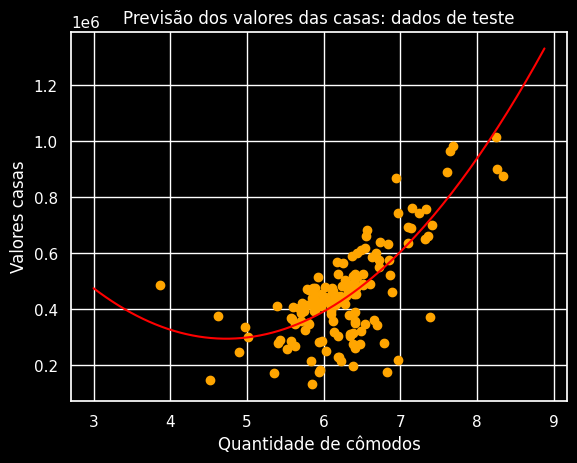

In [172]:
plt.scatter(x_teste,y_teste,c = 'orange')
plt.xlabel('Quantidade de cômodos')
plt.ylabel('Valores casas')
plt.title('Previsão dos valores das casas: dados de teste')
plt.plot(numeros1,valor1,color='red')
plt.show();

In [173]:
x_poly_teste = grau_polinomial.fit_transform(x_teste)
x_poly_teste

array([[ 1.      ,  5.834   , 34.035556],
       [ 1.      ,  6.842   , 46.812964],
       [ 1.      ,  5.403   , 29.192409],
       [ 1.      ,  6.852   , 46.949904],
       [ 1.      ,  6.417   , 41.177889],
       [ 1.      ,  6.406   , 41.036836],
       [ 1.      ,  4.903   , 24.039409],
       [ 1.      ,  6.112   , 37.356544],
       [ 1.      ,  6.163   , 37.982569],
       [ 1.      ,  5.965   , 35.581225],
       [ 1.      ,  6.223   , 38.725729],
       [ 1.      ,  5.837   , 34.070569],
       [ 1.      ,  6.041   , 36.493681],
       [ 1.      ,  4.628   , 21.418384],
       [ 1.      ,  6.727   , 45.252529],
       [ 1.      ,  5.757   , 33.143049],
       [ 1.      ,  6.279   , 39.425841],
       [ 1.      ,  6.51    , 42.3801  ],
       [ 1.      ,  5.807   , 33.721249],
       [ 1.      ,  6.739   , 45.414121],
       [ 1.      ,  7.327   , 53.684929],
       [ 1.      ,  7.135   , 50.908225],
       [ 1.      ,  4.519   , 20.421361],
       [ 1.      ,  5.85    , 34.2

In [174]:
polinomial_teste = LinearRegression()

In [175]:
polinomial_teste.fit(x_poly_teste,y_teste)

LinearRegression()

In [176]:
# Coeficiente de Determinação dados de teste
polinomial.score(x_poly_teste,y_teste)

0.5391879530755566

In [177]:
previsoes_teste = polinomial_teste.predict(x_poly_teste)

### **Métricas**

In [178]:
# Erro médio absoluto
mean_absolute_error(y_teste, previsoes_teste)

88894.00551287511

In [179]:
# Erro quadrático médio
mean_squared_error(y_teste, previsoes_teste)

13149352560.413319

In [180]:
# Raiz do erro quadrático médio (RMSE)
np.sqrt(mean_squared_error(y_teste, previsoes_teste))

114670.6264063004

## **Resultado:**
### **Regressão Linear Simples:** Rˆ2 = 0,57/0,60; RMSE = 99315,5; Rˆ2 Validação Cruzada: 55,97%

### **Regressão Linear Múltipla:** Rˆ2 = 0,73/0,68; RMSE = 96087,3; Rˆ2 Validação Cruzada: 69,25%

### **Regressão Polinomial:** Rˆ2 = 0,59/0,54; RMSE = 114670,62
---

## **Regressão por vetores de suporte**

In [181]:
df.head(2)

,RM,LSTAT,PTRATIO,MEDV,previsao
0,6.575,4.98,15.3,504000.0,632371.739762
1,6.421,9.14,17.8,453600.0,525177.148313


In [182]:
independente = df.iloc[:,0:3].values
independente

array([[ 6.575,  4.98 , 15.3  ],
       [ 6.421,  9.14 , 17.8  ],
       [ 7.185,  4.03 , 17.8  ],
       ...,
       [ 6.976,  5.64 , 21.   ],
       [ 6.794,  6.48 , 21.   ],
       [ 6.03 ,  7.88 , 21.   ]])

In [183]:
independente.shape

(489, 3)

In [184]:
dependente = df.iloc[:,3].values
dependente

array([ 504000.,  453600.,  728700.,  701400.,  760200.,  602700.,
        480900.,  569100.,  346500.,  396900.,  315000.,  396900.,
        455700.,  428400.,  382200.,  417900.,  485100.,  367500.,
        424200.,  382200.,  285600.,  411600.,  319200.,  304500.,
        327600.,  291900.,  348600.,  310800.,  386400.,  441000.,
        266700.,  304500.,  277200.,  275100.,  283500.,  396900.,
        420000.,  441000.,  518700.,  646800.,  732900.,  558600.,
        531300.,  518700.,  445200.,  405300.,  420000.,  348600.,
        302400.,  407400.,  413700.,  430500.,  525000.,  491400.,
        396900.,  743400.,  518700.,  663600.,  489300.,  411600.,
        392700.,  336000.,  466200.,  525000.,  693000.,  493500.,
        407400.,  462000.,  365400.,  438900.,  508200.,  455700.,
        478800.,  491400.,  506100.,  449400.,  420000.,  436800.,
        445200.,  426300.,  588000.,  501900.,  520800.,  480900.,
        501900.,  558600.,  472500.,  466200.,  495600.,  6027

In [185]:
# Separando dados treino e teste
x_treino,x_teste,y_treino,y_teste = train_test_split(independente, dependente, test_size = 0.3, random_state = 0)

In [186]:
x_treino.shape,y_treino.shape

((342, 3), (342,))

In [187]:
x_teste.shape,y_teste.shape

((147, 3), (147,))

In [188]:
# kernil = rbf, linear, polinomial (poly)
svr = SVR(kernel='rbf')
svr.fit(x_treino, y_treino)

SVR()

In [189]:
svr.score(x_treino,y_treino)

-0.006148700884580638

In [190]:
svr.score(x_teste,y_teste)

-0.0029977270958452262

In [191]:
previsoes = svr.predict(x_teste)
previsoes

array([442065.07475616, 442088.85512326, 441967.70405957, 441955.55203201,
       442074.63234728, 441956.37557723, 441975.53383139, 442021.79626105,
       442045.68401441, 442005.41384176, 441948.58967011, 441986.51399343,
       442078.04875004, 441988.87499692, 442057.23180757, 441969.83735928,
       442035.71795023, 442089.24844947, 441987.17028651, 442100.87158274,
       442055.84380797, 442101.64458217, 441998.76611113, 442069.85762005,
       441995.37427833, 442100.42112846, 442084.08537311, 442100.17166195,
       442014.71637645, 442021.90919534, 441960.23712281, 442002.70578916,
       442056.11591776, 442100.29564592, 442031.04492803, 442099.81319579,
       442073.72420967, 441947.44191195, 442066.42154521, 442099.96913469,
       441949.06079501, 441967.75057533, 442034.87510966, 442070.48536434,
       441951.02710255, 441998.00307146, 442071.38054163, 441965.59148377,
       442097.26290742, 442013.52257473, 442100.65128061, 442049.10434745,
       442096.19448379, 4

In [192]:
mean_absolute_error(y_teste, previsoes)

124053.8895839421

### Padronização de escala

In [193]:
x_scaler = StandardScaler()
x_treino_scaler = x_scaler.fit_transform(x_treino)
x_treino_scaler

array([[ 0.05327517, -0.70150711, -0.05467118],
       [ 1.12799963, -0.44487061, -0.52922816],
       [ 0.60711128, -0.79792304,  0.230063  ],
       ...,
       [-0.33111532, -0.36121561, -0.33940537],
       [-0.31699486,  0.84398345, -0.29194967],
       [-0.33268427, -0.38815536, -0.90887374]])

In [194]:
y_scaler = StandardScaler()
y_treino_scaler = y_scaler.fit_transform(y_treino.reshape(-1,1))
y_treino_scaler

array([[-1.05925606e-02],
       [ 6.46900118e-01],
       [ 2.85923746e-01],
       [-1.13728667e-01],
       [ 1.44111599e-01],
       [-7.84113359e-01],
       [-1.24822584e+00],
       [-2.81324840e-01],
       [-1.39512694e-01],
       [-1.01616960e+00],
       [ 2.00056152e+00],
       [ 1.21414870e+00],
       [ 1.27860877e+00],
       [-1.52404707e-01],
       [ 9.04740384e-01],
       [ 2.29945267e-03],
       [-2.81324840e-01],
       [ 2.73031732e-01],
       [-2.81324840e-01],
       [ 2.73031732e-01],
       [ 4.27735892e-01],
       [ 2.60139719e-01],
       [-1.06773765e+00],
       [-1.17087376e+00],
       [ 3.49603506e+00],
       [ 9.04740384e-01],
       [-2.07331469e+00],
       [ 1.69895626e-01],
       [ 4.27735892e-01],
       [ 2.76119030e+00],
       [-3.45784907e-01],
       [ 2.73031732e-01],
       [-1.48028208e+00],
       [ 1.57003612e-01],
       [-1.91080747e-01],
       [-1.01616960e+00],
       [ 3.37491799e-01],
       [-2.34845740e-02],
       [ 1.9

In [195]:
x_teste_scaler = x_scaler.transform(x_teste)
x_teste_scaler

array([[-6.24507256e-01, -6.20687880e-01,  1.17917695e+00],
       [ 9.56985082e-01, -8.43295235e-01, -2.61727885e+00],
       [-1.30072075e+00,  1.98112421e+00, -1.81053199e+00],
       [ 9.72674490e-01,  9.82935809e-01,  7.99531373e-01],
       [ 2.90185237e-01, -5.72479917e-01, -3.39405369e-01],
       [ 2.72926888e-01,  9.46070896e-01,  7.99531373e-01],
       [-2.08519115e+00,  2.33134087e+00, -1.81053199e+00],
       [-1.88341711e-01, -2.51777567e-02,  7.99531373e-01],
       [-1.08325729e-01, -2.13755962e-01, -2.44493974e-01],
       [-4.18976010e-01,  1.39296468e-01,  1.17917695e+00],
       [-1.41892805e-02,  1.26651206e+00,  7.99531373e-01],
       [-6.19800434e-01,  4.03022379e-01,  7.99531373e-01],
       [-2.99736508e-01, -7.29864736e-01,  5.14797187e-01],
       [-2.51664988e+00,  3.05162455e+00,  7.99531373e-01],
       [ 7.76556889e-01, -4.85989161e-01,  1.13172126e+00],
       [-7.45315699e-01,  6.32719141e-01,  1.27408835e+00],
       [ 7.36714050e-02, -1.24429444e-01

In [196]:
y_teste_scaler = y_scaler.transform(y_teste.reshape(-1,1))
y_teste_scaler

array([[-2.29756787e-01],
       [ 1.08522857e+00],
       [-1.06773765e+00],
       [ 7.50036225e-01],
       [ 1.18327572e-01],
       [-5.90733160e-01],
       [-1.27400987e+00],
       [ 1.18327572e-01],
       [-3.63765873e-02],
       [-2.68432827e-01],
       [-1.48028208e+00],
       [-1.48028208e+00],
       [-1.65296720e-01],
       [-4.87597053e-01],
       [ 7.50036225e-01],
       [-7.84113359e-01],
       [-2.16864774e-01],
       [ 2.08571666e-01],
       [ 9.25435458e-02],
       [ 1.13679662e+00],
       [ 1.20125669e+00],
       [ 1.44620494e+00],
       [-1.89282650e+00],
       [-8.79446405e-02],
       [-5.39165106e-01],
       [ 3.13505869e+00],
       [ 1.84585736e+00],
       [ 2.65805419e+00],
       [ 2.29945267e-03],
       [-6.21606139e-02],
       [-8.09897386e-01],
       [ 2.29945267e-03],
       [-1.52404707e-01],
       [ 2.52913406e+00],
       [-6.21606139e-02],
       [ 2.58070211e+00],
       [-2.42648800e-01],
       [-1.14508973e+00],
       [ 8.2

In [197]:
svr1 = SVR(kernel='rbf')
#.ravel() é para retornar matriz 1D
svr1.fit(x_treino_scaler, y_treino_scaler.ravel())

SVR()

In [198]:
svr1.score(x_treino_scaler, y_treino_scaler)

0.8714780218682298

### Teste

In [199]:
svr1.score(x_teste_scaler, y_teste_scaler)

0.8141963480712318

In [200]:
previsoes_teste = svr1.predict(x_teste_scaler)
previsoes_teste

array([-2.15791224e-01,  1.10142277e+00, -6.88494535e-01, -1.07563769e+00,
        3.01247352e-01, -9.98869785e-01, -5.59722487e-01, -2.77421653e-01,
       -2.73937823e-02, -4.12691897e-01, -1.16997042e+00, -5.18534667e-01,
       -2.21332947e-02, -1.40012104e+00,  2.00513309e-02, -7.36008350e-01,
       -6.93655466e-02,  5.92234013e-01, -2.48820576e-01,  1.07290408e+00,
        1.76335951e+00,  1.75215955e+00, -1.13186294e+00, -9.89244717e-02,
       -2.62519149e-01,  2.76202189e+00,  1.95334571e+00,  2.71163016e+00,
       -3.10648675e-01, -2.12642736e-01, -9.48038395e-01, -3.73399265e-01,
        1.92487075e-03,  1.41767802e+00, -1.05707405e-01,  2.19221752e+00,
        6.84125100e-02, -1.21422076e+00,  1.73245025e-01,  5.77702833e-01,
       -1.14127434e+00, -3.64357403e-01, -2.10842559e-01,  1.39103054e-01,
       -6.03862563e-01, -4.32397688e-01,  2.77358169e-01, -7.89247973e-01,
        1.58912076e+00, -2.49546698e-01,  1.47592810e+00, -1.13924390e-01,
        8.76296120e-01, -

In [201]:
y_teste_scaler

array([[-2.29756787e-01],
       [ 1.08522857e+00],
       [-1.06773765e+00],
       [ 7.50036225e-01],
       [ 1.18327572e-01],
       [-5.90733160e-01],
       [-1.27400987e+00],
       [ 1.18327572e-01],
       [-3.63765873e-02],
       [-2.68432827e-01],
       [-1.48028208e+00],
       [-1.48028208e+00],
       [-1.65296720e-01],
       [-4.87597053e-01],
       [ 7.50036225e-01],
       [-7.84113359e-01],
       [-2.16864774e-01],
       [ 2.08571666e-01],
       [ 9.25435458e-02],
       [ 1.13679662e+00],
       [ 1.20125669e+00],
       [ 1.44620494e+00],
       [-1.89282650e+00],
       [-8.79446405e-02],
       [-5.39165106e-01],
       [ 3.13505869e+00],
       [ 1.84585736e+00],
       [ 2.65805419e+00],
       [ 2.29945267e-03],
       [-6.21606139e-02],
       [-8.09897386e-01],
       [ 2.29945267e-03],
       [-1.52404707e-01],
       [ 2.52913406e+00],
       [-6.21606139e-02],
       [ 2.58070211e+00],
       [-2.42648800e-01],
       [-1.14508973e+00],
       [ 8.2

### Revertendo a transformação

In [202]:
y_teste_inverse = y_scaler.inverse_transform(y_teste_scaler)
previsoes_inverse = y_scaler.inverse_transform(previsoes_teste.reshape(-1,1))

In [203]:
y_teste_inverse

array([[ 417900.],
       [ 632100.],
       [ 281400.],
       [ 577500.],
       [ 474600.],
       [ 359100.],
       [ 247800.],
       [ 474600.],
       [ 449400.],
       [ 411600.],
       [ 214200.],
       [ 214200.],
       [ 428400.],
       [ 375900.],
       [ 577500.],
       [ 327600.],
       [ 420000.],
       [ 489300.],
       [ 470400.],
       [ 640500.],
       [ 651000.],
       [ 690900.],
       [ 147000.],
       [ 441000.],
       [ 367500.],
       [ 966000.],
       [ 756000.],
       [ 888300.],
       [ 455700.],
       [ 445200.],
       [ 323400.],
       [ 455700.],
       [ 430500.],
       [ 867300.],
       [ 445200.],
       [ 875700.],
       [ 415800.],
       [ 268800.],
       [ 590100.],
       [ 497700.],
       [ 231000.],
       [ 315000.],
       [ 388500.],
       [ 449400.],
       [ 413700.],
       [ 352800.],
       [ 453600.],
       [ 306600.],
       [ 898800.],
       [ 514500.],
       [ 743400.],
       [ 474600.],
       [ 600

In [204]:
previsoes_inverse

array([[420174.87212807],
       [634737.89796179],
       [343175.49828345],
       [280113.15005471],
       [504396.08603148],
       [292617.99343947],
       [364151.37652378],
       [410135.79618577],
       [450863.2230036 ],
       [388101.41673155],
       [264747.14617165],
       [370860.52420003],
       [451720.11197717],
       [227257.55557269],
       [458591.63091728],
       [335435.89942756],
       [444026.37735555],
       [551795.35352618],
       [414794.66988335],
       [630092.44529088],
       [742561.7980311 ],
       [740737.41964992],
       [270954.53338452],
       [439211.47830344],
       [412563.2881634 ],
       [905235.45836988],
       [773508.94404311],
       [897027.07241   ],
       [404723.39514996],
       [420687.73421742],
       [300897.99727853],
       [394501.85450868],
       [455638.98377251],
       [686253.20534829],
       [438106.59583664],
       [812419.14319062],
       [466469.25822128],
       [257539.14000176],
       [4835

In [205]:
# Erro médio Absoluto
mean_absolute_error(y_teste_inverse, previsoes_inverse)

54733.899498823375

In [206]:
# Erro quadrático médio
mean_squared_error(y_teste_inverse, previsoes_inverse)

5390892216.930902

In [207]:
# Raiz do erro quadrático médio (RMSE)
np.sqrt(mean_squared_error(y_teste_inverse, previsoes_inverse))

73422.6955166514

## Validação Cruzada

### Padronização de escala

In [208]:
x = StandardScaler()
independente_scaler = x.fit_transform(independente)
independente_scaler

array([[ 0.52055395, -1.1250769 , -1.5250831 ],
       [ 0.28104837, -0.53706982, -0.33974768],
       [ 1.46924486, -1.25935736, -0.33974768],
       ...,
       [ 1.14420158, -1.03178731,  1.17748167],
       [ 0.86114953, -0.91305511,  1.17748167],
       [-0.32704695, -0.71516812,  1.17748167]])

In [209]:
y = StandardScaler()
dependente_scaler = y.fit_transform(dependente.reshape(-1,1))
dependente_scaler

array([[ 0.30064004],
       [-0.00449803],
       [ 1.66104726],
       [ 1.49576414],
       [ 1.85175855],
       [ 0.89820209],
       [ 0.16078509],
       [ 0.69477671],
       [-0.65291643],
       [-0.34777836],
       [-0.84362772],
       [-0.34777836],
       [ 0.00821606],
       [-0.15706706],
       [-0.43677696],
       [-0.2206375 ],
       [ 0.18621326],
       [-0.52577556],
       [-0.18249524],
       [-0.43677696],
       [-1.02162492],
       [-0.25877975],
       [-0.81819955],
       [-0.90719815],
       [-0.7673432 ],
       [-0.98348267],
       [-0.64020234],
       [-0.86905589],
       [-0.41134879],
       [-0.08078255],
       [-1.1360517 ],
       [-0.90719815],
       [-1.07248127],
       [-1.08519536],
       [-1.03433901],
       [-0.34777836],
       [-0.20792341],
       [-0.08078255],
       [ 0.38963864],
       [ 1.1651979 ],
       [ 1.68647543],
       [ 0.63120628],
       [ 0.46592316],
       [ 0.38963864],
       [-0.05535438],
       [-0

In [210]:
# Separando os dados em folds
kfold = KFold(n_splits = 18, shuffle=True, random_state = 5)

#Criando o modelo
modelo = SVR(kernel = 'rbf')
resultado = cross_val_score(modelo, independente_scaler,dependente_scaler.ravel(), cv = kfold)
resultado

array([0.90266887, 0.87901785, 0.86259612, 0.81012033, 0.84339191,
       0.88987788, 0.70986262, 0.90180513, 0.8266832 , 0.75275531,
       0.84130892, 0.89315126, 0.89919129, 0.67773848, 0.74464219,
       0.84944558, 0.82887686, 0.77481048])

In [211]:
print(f'Coeficiente de Determinação Médio: {round(resultado.mean() * 100,2)}%')

Coeficiente de Determinação Médio: 82.71%


## **Resultado:**
### **Regressão Linear Simples:** Rˆ2 = 0,57/0,60; RMSE = 99315,5; Rˆ2 Validação Cruzada: 55,97%

### **Regressão Linear Múltipla:** Rˆ2 = 0,73/0,68; RMSE = 96087,3; Rˆ2 Validação Cruzada: 69,25%

### **Regressão Polinomial:** Rˆ2 = 0,59/0,54; RMSE = 114670,62

### **Regressão SVR:** Rˆ2 = 0,87/0,81; RMSE = 73422.69; Rˆ2 Validação Cruzada: 82,71%
---

## **Regressão com árvore de decisão**

In [212]:
df.head(2)

,RM,LSTAT,PTRATIO,MEDV,previsao
0,6.575,4.98,15.3,504000.0,632371.739762
1,6.421,9.14,17.8,453600.0,525177.148313


In [213]:
independente = df.iloc[:,0:3].values
independente

array([[ 6.575,  4.98 , 15.3  ],
       [ 6.421,  9.14 , 17.8  ],
       [ 7.185,  4.03 , 17.8  ],
       ...,
       [ 6.976,  5.64 , 21.   ],
       [ 6.794,  6.48 , 21.   ],
       [ 6.03 ,  7.88 , 21.   ]])

In [214]:
independente.shape

(489, 3)

In [215]:
dependente = df.iloc[:, 3].values
dependente

array([ 504000.,  453600.,  728700.,  701400.,  760200.,  602700.,
        480900.,  569100.,  346500.,  396900.,  315000.,  396900.,
        455700.,  428400.,  382200.,  417900.,  485100.,  367500.,
        424200.,  382200.,  285600.,  411600.,  319200.,  304500.,
        327600.,  291900.,  348600.,  310800.,  386400.,  441000.,
        266700.,  304500.,  277200.,  275100.,  283500.,  396900.,
        420000.,  441000.,  518700.,  646800.,  732900.,  558600.,
        531300.,  518700.,  445200.,  405300.,  420000.,  348600.,
        302400.,  407400.,  413700.,  430500.,  525000.,  491400.,
        396900.,  743400.,  518700.,  663600.,  489300.,  411600.,
        392700.,  336000.,  466200.,  525000.,  693000.,  493500.,
        407400.,  462000.,  365400.,  438900.,  508200.,  455700.,
        478800.,  491400.,  506100.,  449400.,  420000.,  436800.,
        445200.,  426300.,  588000.,  501900.,  520800.,  480900.,
        501900.,  558600.,  472500.,  466200.,  495600.,  6027

In [216]:
dependente.shape

(489,)

In [217]:
x_treino,x_teste,y_treino,y_teste = train_test_split(independente,dependente, test_size=0.3, random_state=0)

In [218]:
x_treino.shape,y_treino.shape

((342, 3), (342,))

In [219]:
x_teste.shape,y_teste.shape

((147, 3), (147,))

In [243]:
modelos = {
    'Árvore': DecisionTreeRegressor(max_depth=5,random_state=10),
     'DecisionTreeRegressor': DecisionTreeRegressor(max_depth = 5, random_state=10)
}
class treino_teste():

  def __init__(self,modelos,x_treino,x_teste,y_treino,y_teste):
    self.modelos = modelos
    self.x_treino = x_treino
    self.x_teste = x_teste
    self.y_treino = y_treino
    self.y_teste = y_teste
    self.modelo_score = {}

  def treino(self):

    for nome, model in self.modelos.items():

      model.fit(self.x_treino,self.y_treino)

      resultado_treino = round(model.score(self.x_treino,y_treino) * 100,2)
      resultado_teste = round(model.score(self.x_teste,y_teste) * 100,2)

      self.modelo_score[nome] = ['{:.2f}%'.format(resultado_treino), '{:.2f}%'.format(resultado_teste)]

    md = pd.DataFrame(self.modelo_score,index=['Coeficiente treino','Coeficiente teste'])

    return md

  def previsao(self,modelo,x,y):

    previsao = modelo.predict(x)

    # Erro médio absoluto
    print(f'Erro médio absoluto: {round(mean_absolute_error(y_teste, previsao),2)}\n')

    # Erro quadrático médio
    print(f'\nErro quadrático médio: {round(mean_squared_error(y_teste, previsao),2)}\n')

    # Raiz do erro quadrático médio (RMSE)
    print(f'\nRaiz do erro quadrático médio (RMSE): {round(np.sqrt(mean_squared_error(y_teste, previsao)),2)}')

  def val_cruzada(self,mod,):

    kfold = KFold(n_splits = 15, shuffle = True, random_state = 5)

    resultado = cross_val_score(mod, independente, dependente, cv = kfold)

    #Usando a média e o desvio padrão
    print(f'Coeficiente de determinação médio: {round(resultado.mean() * 100,2)}%')

Treino = treino_teste(modelos,x_treino,x_teste,y_treino,y_teste)
Treino.treino()

,Árvore,DecisionTreeRegressor
Coeficiente treino,90.51%,90.51%
Coeficiente teste,82.57%,82.57%


### Métricas

In [241]:
Treino.previsao(modelo=modelos['Árvore'],x=x_teste,y=y_teste)

Erro médio absoluto: 52954.0


Erro quadrático médio: 5057266756.34


Raiz do erro quadrático médio (RMSE): 71114.46


### Validação Cruzada


In [244]:
Treino.val_cruzada(mod=modelos['DecisionTreeRegressor'])

Coeficiente de determinação médio: 74.6%


## **Resultado:**
### **Regressão Linear Simples:** Rˆ2 = 0,57/0,60; RMSE = 99315,5; Rˆ2 Validação Cruzada: 55,97%

### **Regressão Linear Múltipla:** Rˆ2 = 0,73/0,68; RMSE = 96087,3; Rˆ2 Validação Cruzada: 69,25%

### **Regressão Polinomial:** Rˆ2 = 0,59/0,54; RMSE = 114670,62

### **Regressão SVR:** Rˆ2 = 0,87/0,81; RMSE = 73422.69; Rˆ2 Validação Cruzada: 82,71%

###**Regressão árvore de decisão:** Rˆ2 = 0,91/0,83; RMSE = 71114,5; Rˆ2 Validação Cruzada: 74,60%.
---

## **Regressão com Random Forest**